In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

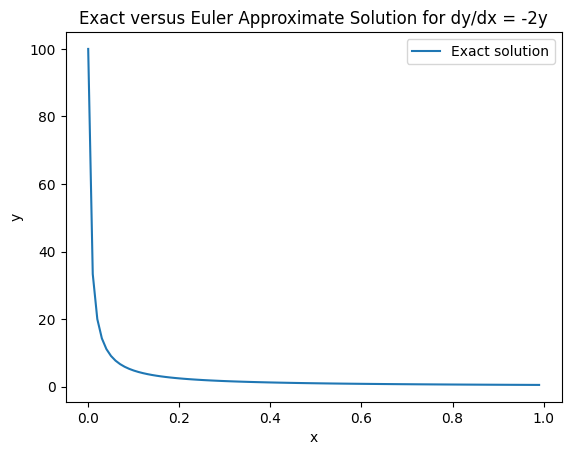

In [14]:
def exact_solution(t):
    return 100/(1 + 200*t)
t = np.arange(0, 1, 0.01)
plt.figure()
plt.plot(t, exact_solution(t), label="Exact solution")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Exact versus Euler Approximate Solution for dy/dx = -2y")
plt.savefig("../../data/euler_approx.png")
plt.show()

In [36]:
def dy_dt(x, y, t, b):
    return b * x - (y * (x**2))
def dx_dt(x, y, t, a, b):
    return a + (y * (x**2)) - b*x - x

In [43]:
A = 1.5
B = 4
x_0 = 5
y_0 = 1

init = [x_0, y_0]
t = np.arange(0, 5, 0.1)
solution = odeint(lambda y, t: [dy_dt(y[0], y[1], t, B), dx_dt(y[0], y[1], t, A, B)], init, t)

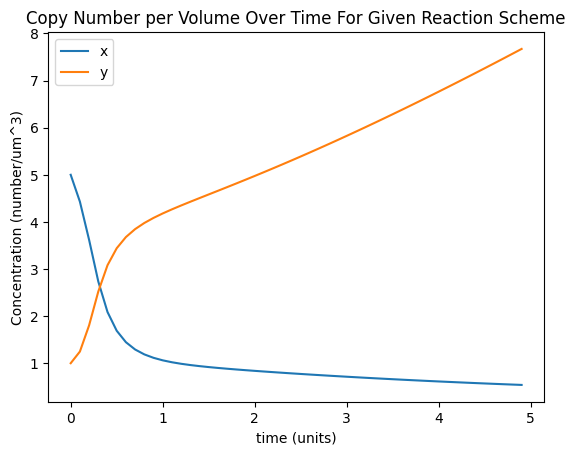

In [45]:
plt.figure()
plt.plot(t, solution[:, 0], label='x')
plt.plot(t, solution[:, 1], label='y')
plt.xlabel('time (units)')
plt.ylabel('Concentration (number/'
           'um^3)')
plt.legend()
plt.title("Copy Number per Volume Over Time For Given Reaction Scheme")
plt.savefig("../../data/reaction_kinetics.png")
plt.show()